# Solving phase and frequency matching conditions for $\chi^{(2)}$  with voxels of increasing resolution.

# Applying voxels of increasing resolution to $\chi^{(3)}$.
Refractive index from:

http://refractiveindex.info/?shelf=main&book=LiNbO3&page=Zelmon-o

see also the notebook Dispersion_relation_chi_2_and_interpolations

In [130]:
import sympy as sp
import numpy as np
import scipy.constants
from sympy.utilities.autowrap import ufuncify
import time
import itertools
#from scipy import interpolate

import matplotlib.pyplot as plt
%matplotlib inline

from sympy import init_printing
init_printing() 
import random

In [131]:
def plot_arr(arr):
    fig = plt.figure(figsize=(15,15))
    ax = fig.add_subplot(111)
    cax = ax.matshow(np.asmatrix(arr), interpolation='nearest')
    fig.colorbar(cax)
    plt.show()

In [132]:
## from https://www.andreas-jung.com/contents/a-python-decorator-for-measuring-the-execution-time-of-methods

def timeit(method):
    def timed(*args, **kw):
        ts = time.time()
        result = method(*args, **kw)
        te = time.time()
        print '%r %2.2f sec' % \
              (method.__name__, te-ts)
        return result
    return timed

In [133]:
lambd,nu,nu1,nu2,nu3,nu4 = sp.symbols('lambda nu nu_1 nu_2 nu_3 nu_4')
l2 = lambd **2

def n_symb(pol='o'):
    s = 1.
    if pol == 'o':
        s += 2.6734 * l2 / (l2 - 0.01764)
        s += 1.2290 * l2 / (l2 - 0.05914)
        s += 12.614 * l2 / (l2 - 474.6)
    else:
        s += 2.9804 * l2 / (l2 - 0.02047)
        s += 0.5981 * l2 / (l2 - 0.0666)
        s += 8.9543 * l2 / (l2 - 416.08)
    return sp.sqrt(s)

def k_symb(symbol=nu,pol='o'):
    '''k is accurate for nu inputs between 6-60.'''
    return ((n_symb(pol=pol) * symbol )
                .subs(lambd,scipy.constants.c / (symbol*1e7))) ## / scipy.constants.c

In [134]:
expressions = [k_symb(nu1,pol='o'), k_symb(nu2,pol='o'), k_symb(nu3,pol='e')]

In [135]:
dispersion_difference_function = sum(expressions)
dispersion_difference_function = dispersion_difference_function.subs(nu3,-nu1-nu2)

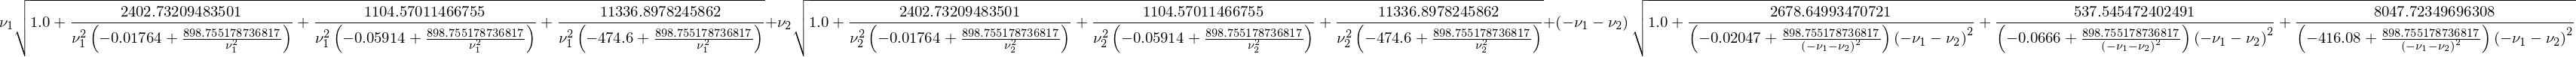

In [136]:
dispersion_difference_function

In [137]:
k_of_nu1_nu2 = ufuncify([nu1,nu2],dispersion_difference_function)

### Find maximum derivative of dispersion_difference_function over a range. This could be used as a bound for $\epsilon$ to guarantee results.

In [9]:
def find_max_der(expression,symbol,input_range):
    expr_der = sp.diff(expression,symbol)
    expr_def_func = ufuncify([symbol],expr_der)
    return max(abs(expr_def_func(input_range)))

In [10]:
## Apply the triangle inequality over a range of nus

nus = np.asarray([6.+ i*5e-2 for i in range(1+int(1e3))])
max_derivative = sum([find_max_der(exp,om,nus) for om,exp in zip([nu1,nu2,nu3],expressions)])

In [11]:
max_derivative

## Methods for systematic search over ranges

### Definitions:
`base` -- The number base to use, i.e. the factor to increase the grid resolution at each step.
`starting_i` -- index of starting step. `0` means we use a grid of size `base` by `base`.
`max_i` -- final index.
`eps` -- desired resolution at step max_i

### Description 

To look for solutions more efficiently, we can recursively enhance the resolution of the grid in which we are looking. At each step, decrease the cutoff `eps_current` by some factor (for now let's make it `base`). For the set of voxels in each step that are close enough to a solution of the equation, increase the resolution by a factor of `base` and examine the resulting smaller voxels. Continue until the last step.

In [274]:
eps = 0.00002
starting_i = 0
max_i = 4
base = 10

In [275]:
min_value = 6.
max_value = 20.

In [276]:
@timeit
def setup_ranges(max_i,base):
    ranges= {}
    for i in range(max_i+1):
        ranges[i] = np.linspace(min_value,max_value,1+pow(base,i+1))
    return ranges

### Note: How to obtain the index of $\nu_3$.

In [277]:
i = 2

In [278]:
1+pow(base,i+1)

In [279]:
np.linspace(min_value,max_value,1+pow(base,i+1))

array([  6.   ,   6.014,   6.028, ...,  19.972,  19.986,  20.   ])

In [280]:
spacing = (max_value-min_value)/ pow(base,i+1)
spacing

In [281]:
num_indices_from_zero = min_value / spacing
num_indices_from_zero

In [282]:
ranges[i]

array([  6.   ,   6.005,   6.01 , ...,  10.99 ,  10.995,  11.   ])

In [283]:
sample_index = solution_containing_voxels[2].keys()[1000]

IndexError: list index out of range

In [284]:
sample_index

In [285]:
ranges[2][(sum(sample_index)+int(num_indices_from_zero))]

### Main methods used

In [286]:
@timeit
def initial_voxels(max_i,base,starting_i,eps):
    solution_containing_voxels = {}
    eps_current = eps * pow(base,max_i-starting_i)
    solution_containing_voxels[starting_i] = {}
    
    for i1,om1 in enumerate(ranges[starting_i]):
        for i2,om2 in enumerate(ranges[starting_i]):
            err = k_of_nu1_nu2(om1,om2)
            if abs(err) < eps_current:
                solution_containing_voxels[starting_i][i1,i2] = err
    return solution_containing_voxels

In [287]:
@timeit
def add_high_res_voxels(max_i,base,starting_i,eps,solution_containing_voxels):
    for i in range(starting_i+1,max_i+1):
        eps_current = eps * pow(base,max_i-i)
        solution_containing_voxels[i] = {}
        for (i1,i2) in solution_containing_voxels[i-1]:
            step_size = int(base/2)
            max_length = pow(base,i+1)
            for i1_new in range(max(0,i1*base-step_size),min(max_length,i1*base+step_size+1)):
                for i2_new in range(max(0,i2*base-step_size),min(max_length,i2*base+step_size+1)):
                    err = k_of_nu1_nu2(ranges[i][i1_new],ranges[i][i2_new])
                    if abs(err) < eps_current:
                        solution_containing_voxels[i][i1_new,i2_new] = err 

In [288]:
@timeit
def plot_voxels(solution_containing_voxels,i):
    voxels = np.zeros((1+pow(base,i+1),1+pow(base,i+1)))
    for (i1,i2) in solution_containing_voxels[i]:
        voxels[i1,i2] = 1
    plot_arr(voxels)

In [289]:
def voxel_solutions(ranges,k_of_nu1_nu2,max_i,base,starting_i,eps):
    solution_containing_voxels = initial_voxels(ranges,k_of_nu1_nu2,max_i,
                                                base,starting_i,eps)
    add_high_res_voxels(ranges,k_of_nu1_nu2,max_i,base,starting_i,eps,
                        solution_containing_voxels)
    return solution_containing_voxels

In [290]:
ranges = setup_ranges(max_i,base)

'setup_ranges' 0.00 sec


In [291]:
solution_containing_voxels = initial_voxels(max_i,base,starting_i,eps)

'initial_voxels' 0.00 sec


In [292]:
add_high_res_voxels(max_i,base,starting_i,eps,solution_containing_voxels)

'add_high_res_voxels' 2.06 sec


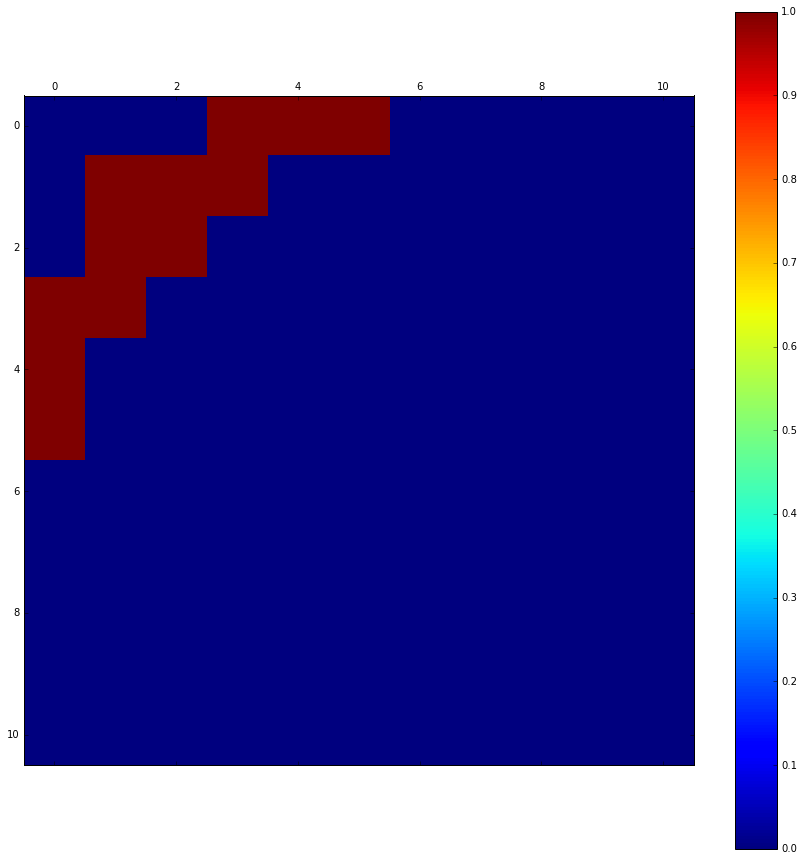

'plot_voxels' 0.54 sec


In [293]:
plot_voxels(solution_containing_voxels,0)

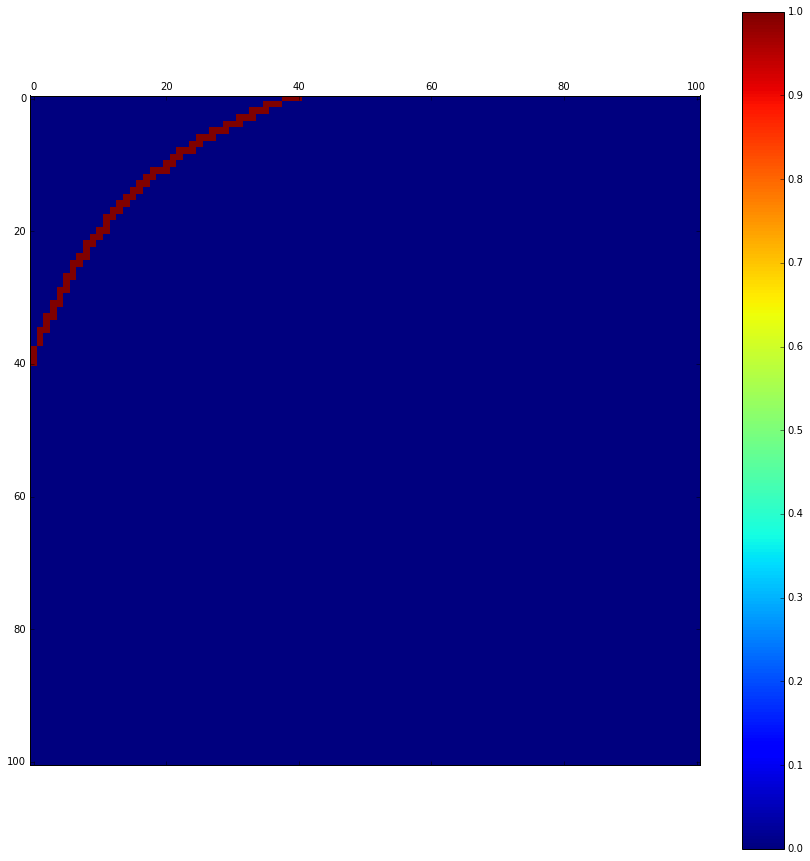

'plot_voxels' 0.60 sec


In [294]:
plot_voxels(solution_containing_voxels,1)

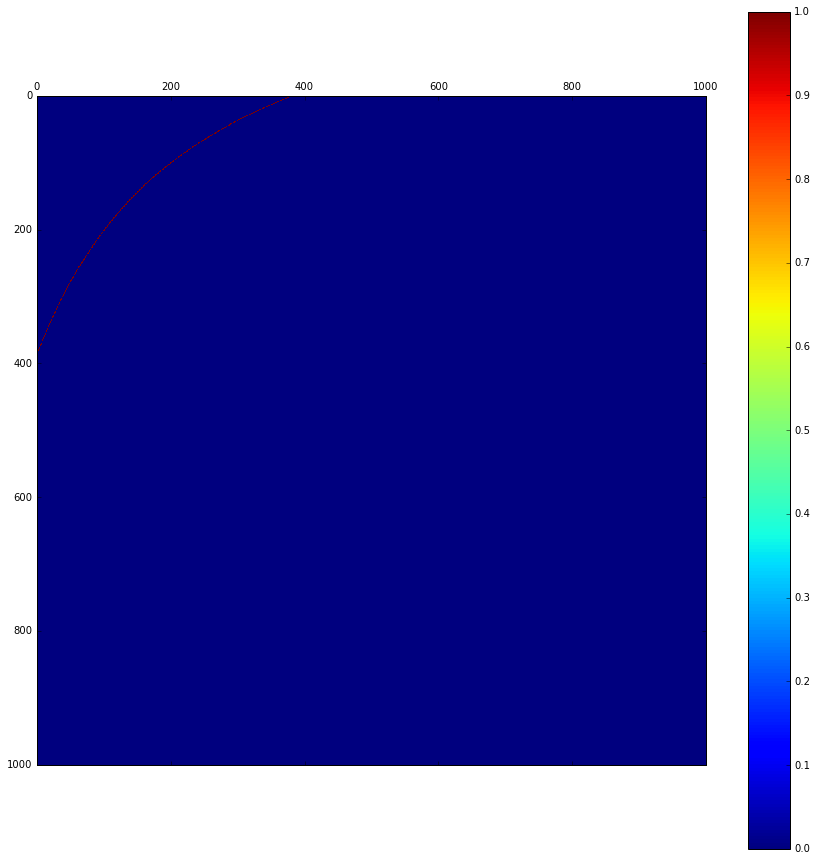

'plot_voxels' 0.63 sec


In [295]:
plot_voxels(solution_containing_voxels,2)

In [296]:
## Number of solutions found for each resolution:

for i in range(0,5):
    print len(solution_containing_voxels[i])

12
79
749
7609
75791


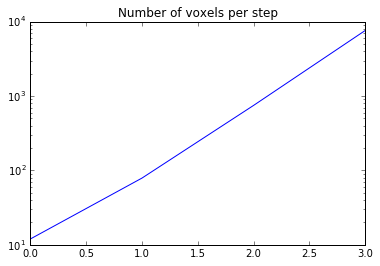

In [297]:
## Number of solutions found for each resolution:
plt.title('Number of voxels per step')
plt.semilogy([(len(solution_containing_voxels[i])) for i in range(0,max_i)])

## Different bases comparison

### Base 10

In [298]:
eps = 0.006
starting_i = 0
max_i = 2
base = 10

In [299]:
## maximum grid length:
1+pow(base,max_i+1)

In [300]:
ranges = setup_ranges(max_i,base)
solution_containing_voxels = initial_voxels(max_i,base,starting_i,eps)
add_high_res_voxels(max_i,base,starting_i,eps,solution_containing_voxels)

'setup_ranges' 0.00 sec
'initial_voxels' 0.00 sec
'add_high_res_voxels' 0.07 sec


In [301]:
## Number of solutions found for each resolution:

for i in range(0,max_i+1):
    print len(solution_containing_voxels[i])

37
239
2265


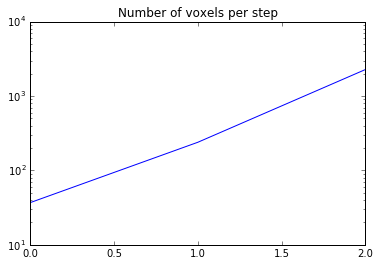

In [302]:
## Number of solutions found for each resolution:
plt.title('Number of voxels per step')
plt.semilogy([(len(solution_containing_voxels[i])) for i in range(0,max_i+1)])

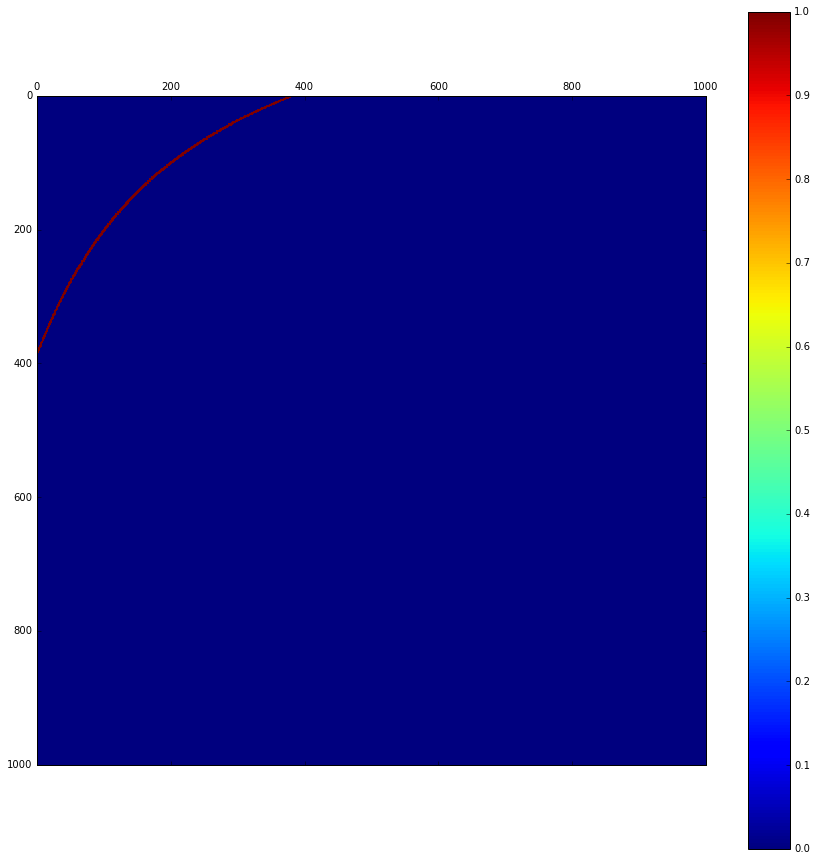

'plot_voxels' 0.63 sec


In [303]:
plot_voxels(solution_containing_voxels,max_i)

### Base 2

In [304]:
eps = 0.006
starting_i = 0
max_i = 9
base = 2

In [305]:
## maximum grid length:
1+pow(base,max_i+1)

In [306]:
ranges = setup_ranges(max_i,base)
solution_containing_voxels = initial_voxels(max_i,base,starting_i,eps)
add_high_res_voxels(max_i,base,starting_i,eps,solution_containing_voxels)

'setup_ranges' 0.00 sec
'initial_voxels' 0.00 sec
'add_high_res_voxels' 0.07 sec


In [307]:
## Number of solutions found for each resolution:

for i in range(0,max_i+1):
    print len(solution_containing_voxels[i])

9
16
32
52
85
158
307
613
1199
2381


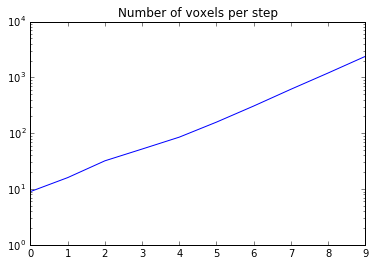

In [308]:
## Number of solutions found for each resolution:
plt.title('Number of voxels per step')
plt.semilogy([(len(solution_containing_voxels[i])) for i in range(0,max_i+1)])

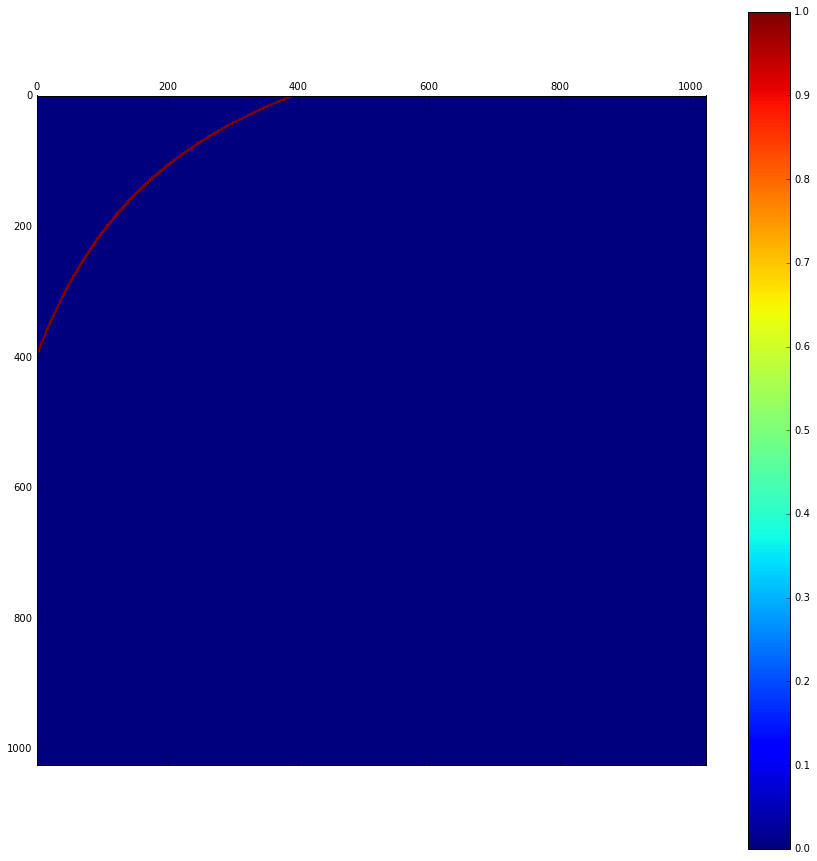

'plot_voxels' 0.69 sec


In [309]:
plot_voxels(solution_containing_voxels,max_i)

## Discussion

The number of solution voxels increases by a factor of `base` at each step. This happens because the function being optimize is close to linear near the solutions and because we decrease `eps_current` by a factor of `base` at each step. As a result, the total number of voxels increases by a factor of `base**2` at each step, but the thickness of the solution voxel surface decreases by a factor of `base`.

The cost of the algorithm is dominated by the last step. This is because the number of voxels increases approximately by a factor of `base` at each step, and the computational cost at each step is the number of voxels from the previous step multiplied by `base**2`. As such, the algorithm runtime is essentially the number of solution points. Notice in the above experiments the runtime was similar for different bases used. 

A more careful analysis assuming a large number of points and the scaling described above gives a geometric series for the runtime, where the sum starts at the last step ($b$ stands for `base` and $p$ stands for number of points):
\begin{align}
b^2(\frac{p}{b} + \frac{p}{b^2} + ...)
=
p\left( b + 1 + \frac{1}{b} + ...\right)
\approx \frac{pb^2}{b-1}.
\end{align}

The other factor contributing to the runtime is breaking away from the scaling law in the above discussion. 

# Using the same technique for $\chi^{(3)}$.

Let's extend the above search technique to using four-wave mixing.

The problems here will be larger, so runtime may be more important. For this reason, I tested different values of epsilon at each stage. Using a smaller epsilon will improve the runtime, but may miss correct solutions. Compare the number of solutions and runtime to the methods used in the notebook Dispersion_relation_two_approaches. The complexity is essentially linear in the number of solutions, but here the constant factor may be large if epsilon is not chosen carefully at each step. For this reason one may prefer to use the other techniques for $\chi^{(3)}$ problems. The number of solutions in the method below converges to the number of solutions using the other two methods.

In [310]:
eps = 2e-4
starting_i = 0
max_i = 1
base = 10

In [311]:
relative_scalings = [4,4,10]

In [312]:
phi1_min = 30.
phi1_max = 34.
ranges1 = {}
for i in range(0,2):
    ranges1[i] = np.linspace(phi1_min,phi1_max,relative_scalings[0]*pow(base,i+1)+1)

phi2_min = -13
phi2_max = -9
ranges2 = {}
for i in range(0,2):
    ranges2[i] = np.linspace(phi2_min,phi2_max,relative_scalings[1]*pow(base,i+1)+1)

nu3_min = -26.
nu3_max = -16.
ranges3 = {}
for i in range(0,2):
    ranges3[i] = np.linspace(nu3_min,nu3_max,relative_scalings[2]*pow(base,i+1)+1)

print len(ranges1[1]),len(ranges2[1]),len(ranges3[1])

401 401 1001


In [313]:
phi1, phi2 = sp.symbols('phi_1 phi_2')

In [314]:
ex1 = (k_symb(nu1,pol='e')+k_symb(nu2,pol='e')).expand().subs({nu1:(phi1 + phi2)/2, nu2: (phi1-phi2)/2})

In [315]:
ex2 = -(k_symb(nu3,pol='e')+k_symb(nu4,pol='e')).expand().subs(nu4,-phi1-nu3)

In [316]:
f_phi12_nu3 =ufuncify([phi1,phi2,nu3], ex1-ex2)

In [317]:
@timeit
def initial_voxels_4wv(max_i,base,starting_i,eps,eps_factor = None):

    if eps_factor is None:
        eps_factor = pow(base,max_i-starting_i)
    eps_current = eps * eps_factor
        
    solution_containing_voxels = {}
    solution_containing_voxels[starting_i] = {}
    
    for i1,om1 in enumerate(ranges1[starting_i]):
        for i2,om2 in enumerate(ranges2[starting_i]):
            for i3,om3 in enumerate(ranges3[starting_i]):
                err = f_phi12_nu3(om1,om2,om3)
                if abs(err) < eps_current:
                    solution_containing_voxels[starting_i][i1,i2,i3] = err
    return solution_containing_voxels

In [318]:
@timeit
def add_high_res_voxels_4wv(max_i,base,starting_i,eps,solution_containing_voxels):
    for i in range(starting_i+1,max_i+1):
        eps_current = eps * pow(base,max_i-i)
        solution_containing_voxels[i] = {}
        for (i1,i2,i3) in solution_containing_voxels[i-1]:
            step_size = int(base/2)
            max_length = pow(base,i+1)
            for i1_new in range(max(0,i1*base-step_size),min(relative_scalings[0]*max_length,i1*base+step_size+1)):
                for i2_new in range(max(0,i2*base-step_size),min(relative_scalings[1]*max_length,i2*base+step_size+1)):
                    for i3_new in range(max(0,i3*base-step_size),min(relative_scalings[2]*max_length,i3*base+step_size+1)):
                        err = f_phi12_nu3(ranges1[i][i1_new],ranges2[i][i2_new],ranges3[i][i3_new])
                        if abs(err) < eps_current:
                            solution_containing_voxels[i][i1_new,i2_new,i3_new] = err 

In [319]:
eps_factors = [1.5,2.,2.5,3.,3.5,4.]
num_found = {}

In [320]:
for eps_factor in eps_factors:
    solution_containing_voxels_4wv = initial_voxels_4wv(max_i,base,starting_i,eps,eps_factor = eps_factor)
    print 'big voxels: ', len(solution_containing_voxels_4wv[0].keys())
    add_high_res_voxels_4wv(max_i,base,starting_i,eps,solution_containing_voxels_4wv)
    num_found[eps_factor] = len(solution_containing_voxels_4wv[1].keys())
    print 'little voxels: ', num_found[eps_factor]

'initial_voxels_4wv' 0.41 sec
big voxels:  6184
'add_high_res_voxels_4wv' 26.67 sec
little voxels:  3766866
'initial_voxels_4wv' 0.41 sec
big voxels:  7776
'add_high_res_voxels_4wv' 34.65 sec
little voxels:  3979085
'initial_voxels_4wv' 0.40 sec
big voxels:  9295
'add_high_res_voxels_4wv' 38.42 sec
little voxels:  4094222
'initial_voxels_4wv' 0.39 sec
big voxels:  10772
'add_high_res_voxels_4wv' 45.57 sec
little voxels:  4158570
'initial_voxels_4wv' 0.38 sec
big voxels:  12168
'add_high_res_voxels_4wv' 50.95 sec
little voxels:  4193377
'initial_voxels_4wv' 0.38 sec
big voxels:  13556
'add_high_res_voxels_4wv' 56.38 sec
little voxels:  4208929


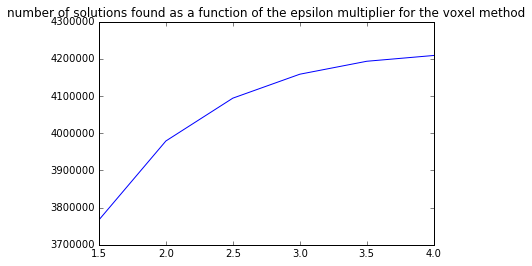

In [321]:
plt.title('number of solutions found as a function of the epsilon multiplier for the voxel method')
plt.plot(eps_factors, [num_found[eps] for eps in eps_factors] )

## Finding solutions in the voxels:

In general the nus to be considered do not lie on a grid. For this reason it is necessary to find which nus lie in each voxel.

### Setup for the experiment

In [322]:
eps = 0.006
starting_i = 0
max_i = 2
base = 10

In [323]:
ranges = setup_ranges(max_i,base)
solution_containing_voxels = initial_voxels(max_i,base,starting_i,eps)
add_high_res_voxels(max_i,base,starting_i,eps,solution_containing_voxels)

'setup_ranges' 0.00 sec
'initial_voxels' 0.00 sec
'add_high_res_voxels' 0.08 sec


In [324]:
i = 2  ## where to draw points from.

In [325]:
scale = 0.1  ## scale on random noise to add to points
Delta = ranges[i][1] - ranges[i][0]  ## Delta here was made with ranges[0] spacing
range_min = ranges[i][0]
ranges_perturbed = [num+random.random()*scale for num in ranges[2]] ## make 

In [326]:
values = [ int(round( (el - range_min) / Delta)) for el in ranges_perturbed]

In [327]:
def make_dict_values_to_lists_of_inputs(values,inputs):
    D = {}
    for k, v in zip(values,inputs):
        D.setdefault(k, []).append(v)
    return D

In [328]:
D = make_dict_values_to_lists_of_inputs(values,ranges_perturbed)

In [329]:
solution_nus = []
for indices in solution_containing_voxels[i].keys(): 
    if all([ind in D for ind in indices]): ## check all indices are in D,
        for it in itertools.product(*[D[ind] for ind in indices]): ## get all nus in the voxel.
            solution_nus.append(it)

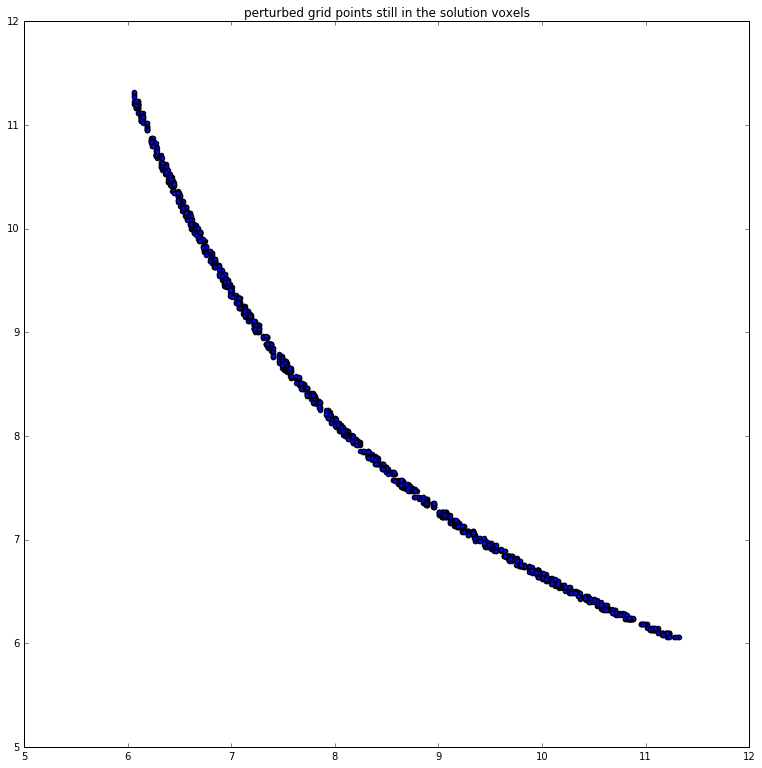

In [330]:
plt.figure(figsize=(13,13))
plt.title('perturbed grid points still in the solution voxels')
plt.scatter([el[0] for el in solution_nus],[el[1] for el in solution_nus])

### Development for method to be used in the package

In [333]:
def setup_ranges(max_i,base,min_value = 6.,max_value = 11.):
    ranges= {}
    for i in range(max_i+1):
        ranges[i] = np.linspace(min_value,max_value,1+pow(base,i+1))
    return ranges

@timeit
def initial_voxels(ranges,k_of_nu1_nu2,max_i,base,starting_i,eps):
    solution_containing_voxels = {}
    eps_current = eps * pow(base,max_i-starting_i)
    solution_containing_voxels[starting_i] = {}

    for i1,om1 in enumerate(ranges[starting_i]):
        for i2,om2 in enumerate(ranges[starting_i]):
            err = k_of_nu1_nu2(om1,om2)
            if abs(err) < eps_current:
                solution_containing_voxels[starting_i][i1,i2] = err
    return solution_containing_voxels

@timeit
def add_high_res_voxels(ranges,k_of_nu1_nu2,max_i,base,starting_i,eps,solution_containing_voxels):
    for i in range(starting_i+1,max_i+1):
        eps_current = eps * pow(base,max_i-i)
        solution_containing_voxels[i] = {}
        for (i1,i2) in solution_containing_voxels[i-1]:
            step_size = int(base/2)
            max_length = pow(base,i+1)
            for i1_new in range(max(0,i1*base-step_size),min(max_length,i1*base+step_size+1)):
                for i2_new in range(max(0,i2*base-step_size),min(max_length,i2*base+step_size+1)):
                    err = k_of_nu1_nu2(ranges[i][i1_new],ranges[i][i2_new])
                    if abs(err) < eps_current:
                        solution_containing_voxels[i][i1_new,i2_new] = err

@timeit
def plot_voxels(solution_containing_voxels,i):
    voxels = np.zeros((1+pow(base,i+1),1+pow(base,i+1)))
    for (i1,i2) in solution_containing_voxels[i]:
        voxels[i1,i2] = 1
    plot_arr(voxels)

def voxel_solutions(ranges,k_of_nu1_nu2,max_i,base,starting_i,eps):
    solution_containing_voxels = initial_voxels(ranges,k_of_nu1_nu2,max_i,
                                                base,starting_i,eps)
    add_high_res_voxels(ranges,k_of_nu1_nu2,max_i,base,starting_i,eps,
                        solution_containing_voxels)
    return solution_containing_voxels

In [334]:
def generate_k_func(pols=(1,1,-1),n_symb = None):

    lambd,nu,nu1,nu2,nu3,nu4 = sp.symbols(
        'lambda nu nu_1 nu_2 nu_3 nu_4')
    l2 = lambd **2

    if n_symb is None:
        def n_symb(pol=1):
            '''Valid for lambda between 0.5 and 5. (units are microns)'''
            s = 1.
            if pol == 1:
                s += 2.6734 * l2 / (l2 - 0.01764)
                s += 1.2290 * l2 / (l2 - 0.05914)
                s += 12.614 * l2 / (l2 - 474.6)
            else:
                s += 2.9804 * l2 / (l2 - 0.02047)
                s += 0.5981 * l2 / (l2 - 0.0666)
                s += 8.9543 * l2 / (l2 - 416.08)
            return sp.sqrt(s)

    def k_symb(symbol=nu,pol=1):
        '''k is accurate for nu inputs between 6-60 (units are 1e13 Hz).'''
        return ((n_symb(pol=pol) * symbol )
                    .subs(lambd,scipy.constants.c / (symbol*1e7)))

    expressions = [k_symb(nu1,pols[0]),
                   k_symb(nu2,pols[1]),
                   k_symb(nu3,pols[2])]
    dispersion_difference_function = sum(expressions)
    dispersion_difference_function = dispersion_difference_function.subs(
                                     nu3,-nu1-nu2)
    k_of_nu1_nu2 = ufuncify([nu1,nu2],
                                   dispersion_difference_function)
    return k_of_nu1_nu2

In [335]:
pols = (1,1,-1)
k_of_nu1_nu2 = generate_k_func(pols)

eps = 0.006
starting_i = 0
max_i = 2
base = 10

min_value = 6.
max_value = 20.
ranges = setup_ranges(max_i,base,min_value,max_value)


In [384]:
pos_nus_lst = np.random.uniform(min_value,max_value,1000) ## 100 random values

Delta = ranges[max_i][1] - ranges[max_i][0] ## spacing in grid used

## get index values
values = [ int(round( (freq - min_value) / Delta)) for freq in pos_nus_lst]

## make a dict to remember which frequencies belong in which grid voxel.
grid_indices_to_unrounded = make_dict_values_to_lists_of_inputs(values,pos_nus_lst)
grid_indices_to_ham_index = make_dict_values_to_lists_of_inputs(values,range(len(pos_nus_lst)))

solution_containing_voxels = voxel_solutions(ranges,k_of_nu1_nu2,
    max_i,base,starting_i,eps)

## Let's figure out which indices we can expect for nu3
spacing = (max_value-min_value)/ pow(base,max_i+1)
num_indices_from_zero = min_value / spacing  ## float, round up or down

solutions_nu1_and_nu2 = solution_containing_voxels[max_i].keys()

solution_indices = []
for indices in solutions_nu1_and_nu2:
    for how_to_round_last_index in range(2):
        last_index = (sum(indices)
                      + int(num_indices_from_zero)
                      + how_to_round_last_index)
        if last_index < 0 or last_index >= len(ranges[max_i]):
            print "breaking!"
            break
        current_grid_indices = (indices[0],indices[1],last_index)
        if all([ind in grid_indices_to_ham_index for ind in current_grid_indices]):
            for it in itertools.product(*[grid_indices_to_ham_index[ind] for ind in current_grid_indices]):
                solution_indices.append(it)

'initial_voxels' 0.00 sec
'add_high_res_voxels' 0.06 sec


In [385]:
len(solutions_nu1_and_nu2)

In [386]:
len(solution_indices)

In [374]:
sample_indices = solution_indices[random.randint(0,len(solution_indices)-1)]

In [375]:
sample_indices

In [376]:
pos_nus_lst[sample_indices[0]], pos_nus_lst[sample_indices[1]], pos_nus_lst[sample_indices[2]] 

In [377]:
pos_nus_lst[sample_indices[0]]+pos_nus_lst[sample_indices[1]] - pos_nus_lst[sample_indices[2]] 

In [395]:
np.zeros((0,0))

array([], shape=(0, 0), dtype=float64)